In [1]:
import argparse
import os
import requests
from datetime import datetime
import json
from tqdm import tqdm

from lib.utils import *
from lib.datasets import WindowedEEGDataset
from torch.utils.data import DataLoader,TensorDataset
from torch.nn.functional import softmax,batch_norm,relu
from torch import nn
import torch
from lib.models import ResNet

device = 'cuda'
data_dir = 'data_pt'
warmstart = False

/home/andrew/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
idx = torch.arange(0,276399-5)
from sklearn.model_selection import train_test_split
train_idx,dev_idx = train_test_split(idx,test_size=.2)
trainloader = DataLoader(train_idx,batch_size=256,shuffle=True)
devloader = DataLoader(dev_idx,batch_size=32,shuffle=False)
dataset = WindowedEEGDataset(dir='data/pt_collapsed/',labels='data/pt_collapsed/labels.pt')

In [15]:
class CNNLSTM(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.resnet = ResNet().cuda()
        self.lstm = nn.LSTM(3,3)
        self.fc1 = nn.Linear(3,3)
    def forward(self,x_2d):
        x = torch.Tensor().cuda()
        for t in range(x_2d.size(1)):
            x_i = self.resnet(x_2d[:,t,:,:])
            x = torch.cat([x,x_i.unsqueeze(0)])
        out,_ = self.lstm(x)
        x = self.fc1(out)        
        return x.view(-1,5,3)

In [16]:
model = CNNLSTM().cuda()
# model = ResNet().cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=3e-4)
train_losses = []
dev_losses = []

In [17]:
lossi = []
trainloader_iter = iter(trainloader)

In [18]:
X,y = dataset[next(trainloader_iter)]

In [21]:
model.train()
for i in range(1000):
    logits = model(X.cuda())
    loss = criterion(logits,y.cuda())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
print(loss)
# 2.3177

tensor(2.6183, device='cuda:0', grad_fn=<DivBackward1>)


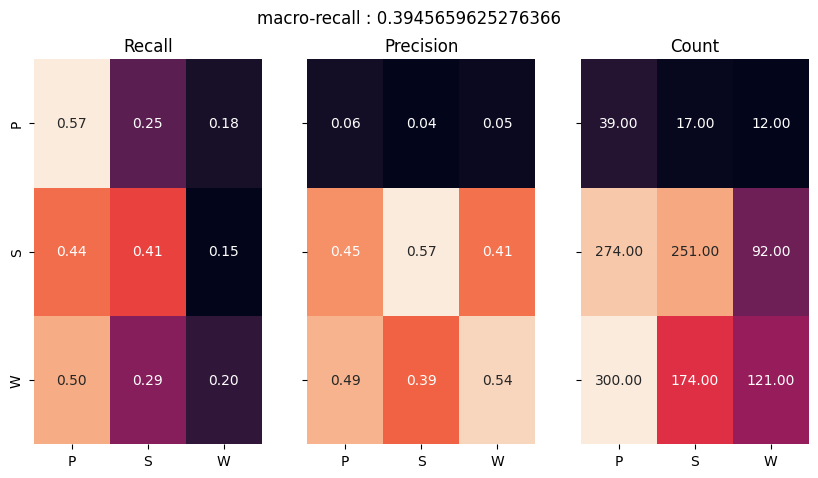

In [22]:
y_true = torch.Tensor().cuda()
y_pred = torch.Tensor().cuda()
model.eval()
X,y = X.cuda(),y.cuda()
logits = model(X)
y_pred_i = torch.softmax(logits,dim=2).argmax(dim=2).flatten()
y_true_i = y.argmax(dim=2).flatten()
y_true = torch.cat([y_true,y_true_i])
y_pred = torch.cat([y_pred,y_pred_i])
cms(y_true=y_true.detach().cpu(),y_pred=y_pred.detach().cpu(),current_date=None)

In [263]:
dev_iter = iter(devloader)
y_true = torch.Tensor().cuda()
y_pred = torch.Tensor().cuda()
model.eval()
for i in range(10):
    X,y = dataset[next(dev_iter)]
    X,y = X.cuda(),y.cuda()
    logits = model(X)
    y_pred_i = torch.softmax(logits,dim=2).argmax(dim=2).flatten()
    y_true_i = y.argmax(dim=2).flatten()
    y_true = torch.cat([y_true,y_true_i])
    y_pred = torch.cat([y_pred,y_pred_i])

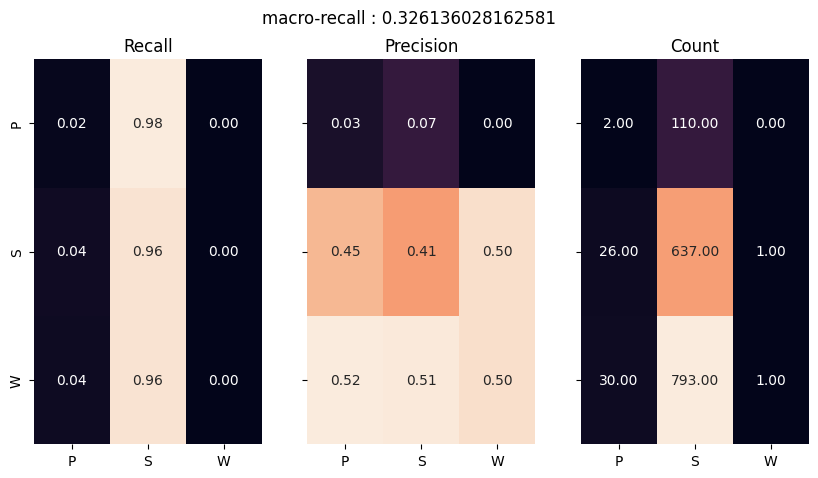

In [269]:
cms(y_true=y_true.detach().cpu(),y_pred=y_pred.detach().cpu(),current_date=None)

In [ ]:
for idx in trainloader:
    X,y = dataset[idx]
    X,y = X.cuda(),y.cuda()
    model.train()
    logits = model(X)
    loss = criterion(logits,y.cuda())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    lossi.append(loss.item())

In [ ]:
plt.plot(lossi)

In [ ]:
for epoch in tqdm(range(100)):
    total_loss = 0
    model.train()
    for X,y in trainloader:
        logits = model(X.view(-1,1,500).cuda())
        loss = criterion(logits,y.cuda())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss/len(trainloader))
    model.eval()
    testing_loss = 0
    for (X,y) in testloader:
        X,y = X.to(device), y.to(device)
        logits = model(X.view(-1,1,500))
        loss = criterion(logits,y)
        testing_loss += loss.item()
    dev_losses.append(testing_loss/len(testloader))

In [ ]:
plt.plot(train_losses)
plt.plot(dev_losses)